In [1]:
from pypsdm.models.input.container.participants import SystemParticipantsContainer
from pypsdm.models.result.container.participants import ParticipantsResultContainer
from pypsdm.models import gwr
from pypsdm.analysis.concurrency import (calc_glg, curve_regression, do_all_glg_plots, get_installed_capacity)
from datetime import datetime
from pypsdm.processing.series import quarter_hourly_mean_resample
import pandas as pd
import os

# Get the folder path where the files are located
#folder_inputs = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\input\grid'
#folder_res = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\rawOutputData'
#folder_glz_cases = r'C:\tmp\20231121_flex_testminigrid_2023-11-21_08-37-58\input\GLZ'
folder_inputs = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\input\grid'
folder_res = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\rawOutputData'
folder_glz_cases = r'C:\tmp\20231113_flex_testgrid_2023-12-18_14-06-09\input\GLZ'
# endtime = datetime(2020,1,1)
endtime = datetime(2019, 12, 31)


file_name_glz_cases = 'em_to_case_dict.csv'
em_cases_dict = pd.read_csv(os.path.join(folder_glz_cases, file_name_glz_cases), index_col=0).rename_axis(index='em_uuid')


gwr = gwr.GridWithResults.from_csv('flex_minigrid', folder_inputs,',',folder_res,',', simulation_end=endtime)


In [2]:
from pypsdm.analysis.concurrency import (get_installed_capacity)
df_input = em_cases_dict.index.tolist()
em_installed_capacity_res_2 = get_installed_capacity(df_input,gwr)


In [45]:
from pypsdm.analysis.concurrency import getCasesFromConditions

# Vorhandene Fälle
# PV immer an
# 1. Spalte: BS
# 2. Spalte: EV
# 3. Spalte: HP vorhanden
# 4. Spalte: neue HP & Dämmung


cases = [
    (1, 1, 1, 1),
    (1, 1, 1, 0),
    (1, 1, 0, 1),
    (1, 1, 0, 0),
    (1, 0, 1, 1),
    (1, 0, 1, 0),
    (1, 0, 0, 1),
    (1, 0, 0, 0),
    (0, 1, 1, 1),
    (0, 1, 1, 0),
    (0, 1, 0, 1),
    (0, 1, 0, 0),
    (0, 0, 1, 1),
    (0, 0, 1, 0),
    (0, 0, 0, 1),
    (0, 0, 0, 0),
]

# Resultierende Fälle für GLZ => Remove wenn 3. Spalte == 1 und Spalte 1 und 2 nicht 1

filtered_cases = [case for case in cases if case[2] != 0 or case[0] == 1 or case[1] == 1]

filtered_cases

# Fälle Binär-codiert (1,1,1,1 ==15)
# Gemeinsame Analyse von 
# Fall 14 und Fall 15 (identisch nur neue oder alte WP & Dämmung) => BS + EV + WP
# 13 und 12 (identisch) => BS + EV
# 11 und 10 (identisch nur neue oder alte WP & Dämmung) BS + WP 
# 9 und 8 (identisch) => Nur BS
# 7 und 6 (identisch nur neue oder alte WP & Dämmung) => EV + WP 
# 4 und 5 (identisch) => Nur EV
# 2 und 3 (identisch nur neue oder alte WP & Dämmung) => Nur WP


test = getCasesFromConditions(em_cases_dict, 0,0,1,1)


In [46]:
import uuid

new_df = pd.DataFrame() 
for item in test:
    data_for_item = gwr.results.participants.ems[item].p
    new_column_name = item
    new_df[new_column_name] = data_for_item
    

In [47]:
len(new_df.columns)

7

In [48]:
# Parameter, die einzustellen sind:
#num_vehicles = 100
# len_curve = 150  # Ziel: 150, gibt die maximale Anzahl an EV innerhalb der GZ-Kurve an
len_curve = min(len(new_df.columns),150)   # Ziel: 150, gibt die maximale Anzahl an EV innerhalb der GZ-Kurve an
num_mc = 300  # Ziel: 1000, Anzahl an Monte-Carlo-Iterationen pro Punkt in der GZ-Kurve

"""
 Initialisierung
"""

# Initialisierung
#temp_profile = pd.DataFrame(np.zeros(shape=(0, num_vehicles)))
#temp_sim = pd.DataFrame(np.zeros(shape=(num_mc, 1)))

# Einlesen der Daten:

# FIXME: s anstatt P?
df_resample = quarter_hourly_mean_resample(new_df)
# df_resample = df_resample.filter(em_installed_capacity_res.index)
# df_norm = normalize_dataframe_by_installed_capacity(df_resample, em_installed_capacity_res)
# df_norm = normalize_dataframe_min_max(df_resample)
df = df_resample

sim_curve, quantile_95, quantile_95_tot, quantile_95_indices = calc_glg(df,em_installed_capacity_res_2, len_curve, num_mc)


Calculate coincidence factor for system participant number 1
Calculate coincidence factor for system participant number 2
Calculate coincidence factor for system participant number 3
Calculate coincidence factor for system participant number 4
Calculate coincidence factor for system participant number 5
Calculate coincidence factor for system participant number 6
Calculate coincidence factor for system participant number 7


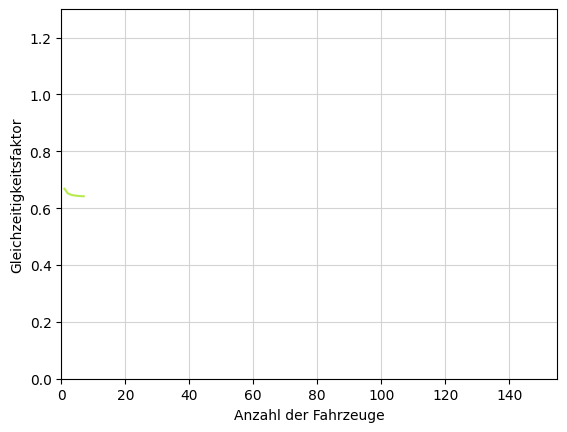

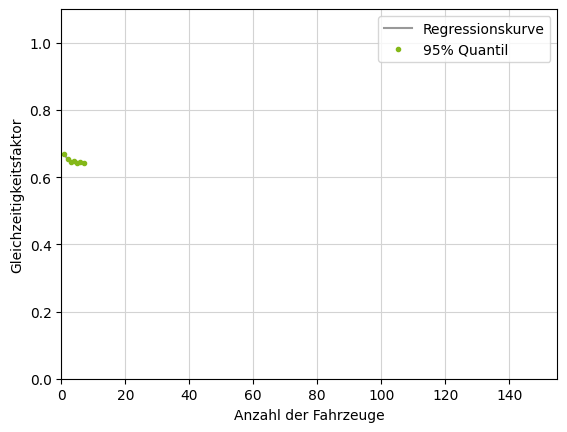

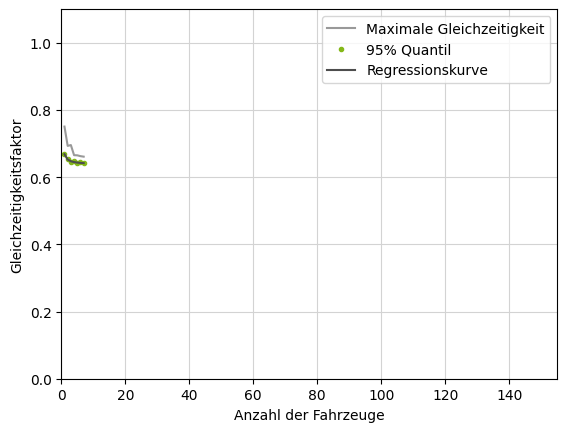

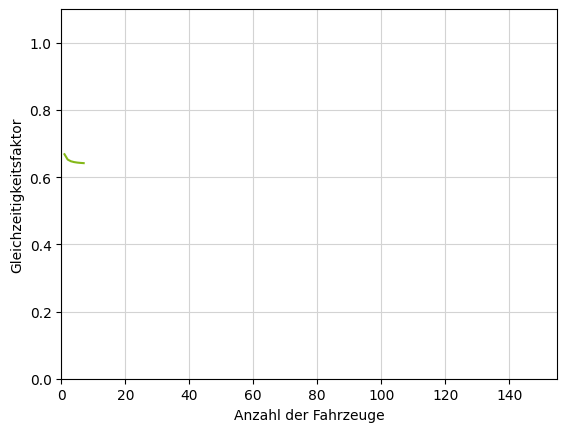

In [49]:
x,y = curve_regression(quantile_95_indices,quantile_95, quantile_95_tot)
do_all_glg_plots(x,y,sim_curve,quantile_95_tot)